### *IMPORTING NECESSARY LIBRARIES *

In [ ]:
import pandas as pd
import numpy as np
import os
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns

### "Dataset path"

In [ ]:
audio_dataset_path = '/content/drive/MyDrive/GTZAN PROJECT DATA/genres_original'
metadata=pd.read_csv('/content/drive/MyDrive/GTZAN PROJECT DATA/features_30_sec.csv')
metadata.head()

### Resolving feature extraction function

Mel Frequency Cepstral Coefficients

In [ ]:
def features_extractor(file):
  audio,sample_rate = librosa.load(file_name, res_type='kaiser_fast')
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

  return mfccs_scaled_features

Next, we will iterate through each audio file and extract the desired features of each file. All this will be done using he same i.e. using Mel_Frequency Cepstral Coefficients

In [ ]:
from tqdm import tqdm

extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
  try:
    final_class_labels=row["label"]
    file_name = os.path.join(os.path.abspath(audio_dataset_path), final_class_labels+'/', str(row["filename"]))
    data = features_extractor(file_name)
    extracted_features.append([data, final_class_labels])
  except Exception as e:
    print(f"Error : {e}")
    continue

Next, we have converted the extracted features to Pandas Datraframe having two main attributes i.e. "Features" and "Class".

In [ ]:
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature','class'])
extracted_features_df.head()

In [ ]:
extracted_features_df['class'].value_counts()

Next, we split the dataset into an independent and dependent dataset

In [ ]:
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
y.shape

Next, we split our dataset for training and testing seperately

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=32)

In [ ]:
X_train

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
num_labels = y.shape[1]

In [ ]:
model = Sequential()
model.add(Dense(1024, input_shape=(40,), activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(num_labels, activation="softmax"))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer = 'adam')

In [ ]:
import time
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath = f'saved_models/audio_classification_{current_time}.hdf5', verbose = 1, save_best_only = True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size = num_batch_size, epochs=num_epochs, validation_data=(X_test,y_test), callbacks=[checkpointer], verbose = 1)

duration = datetime.now() - start
print("Trainign completed in time : ", duration)

In [ ]:
model.evaluate(X_test,y_test,verbose=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

4/4 [==============================] - 0s 5ms/step


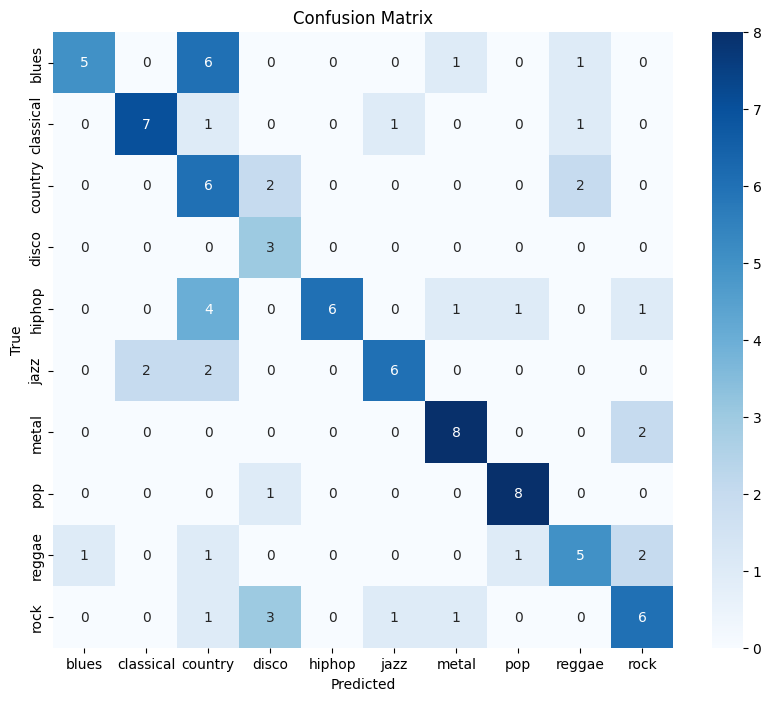

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

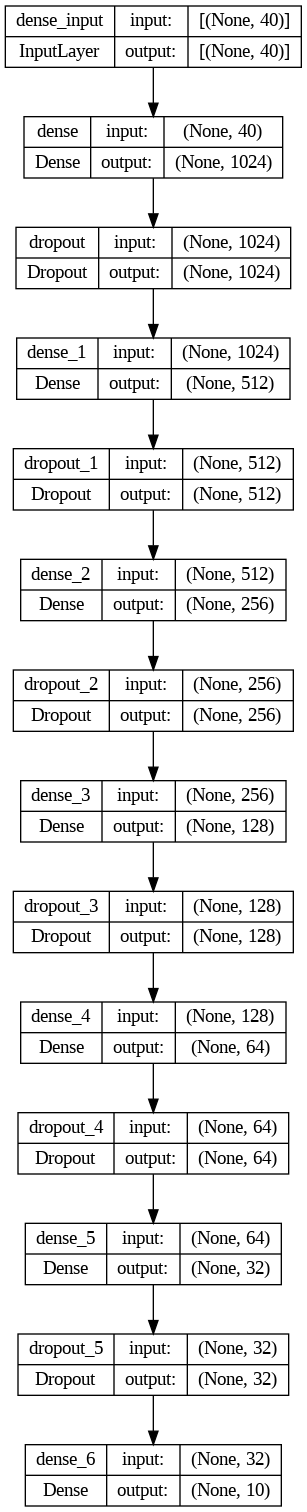

In [ ]:
# Visualize the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


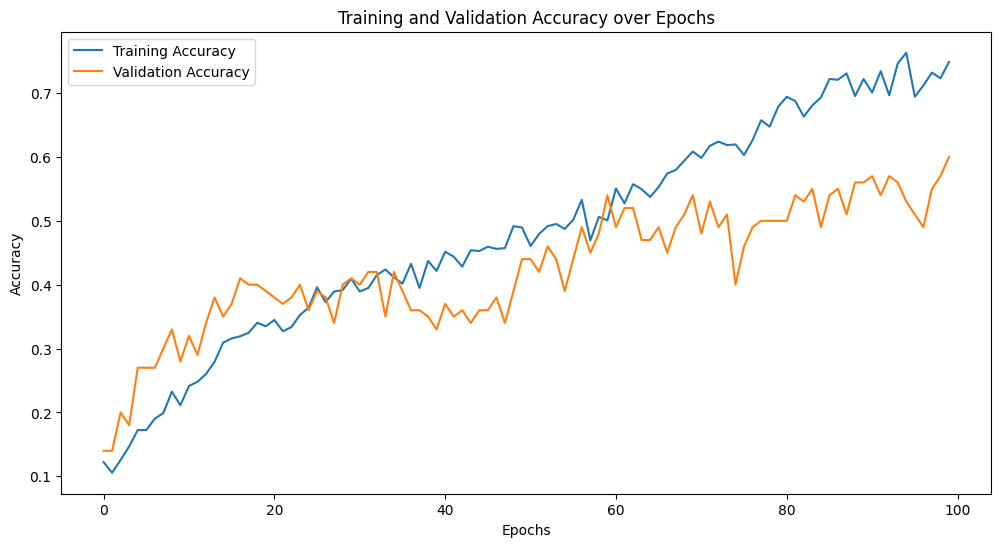

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


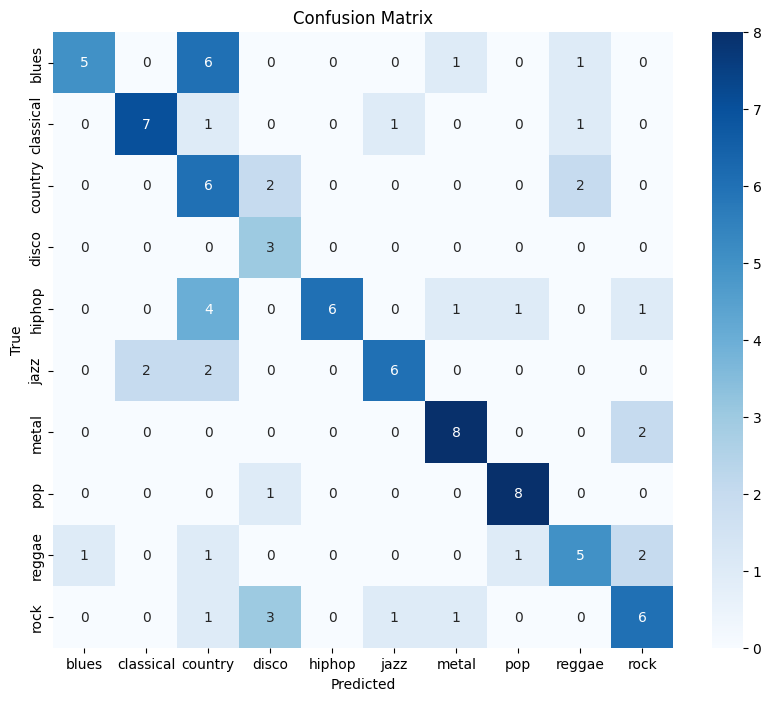

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


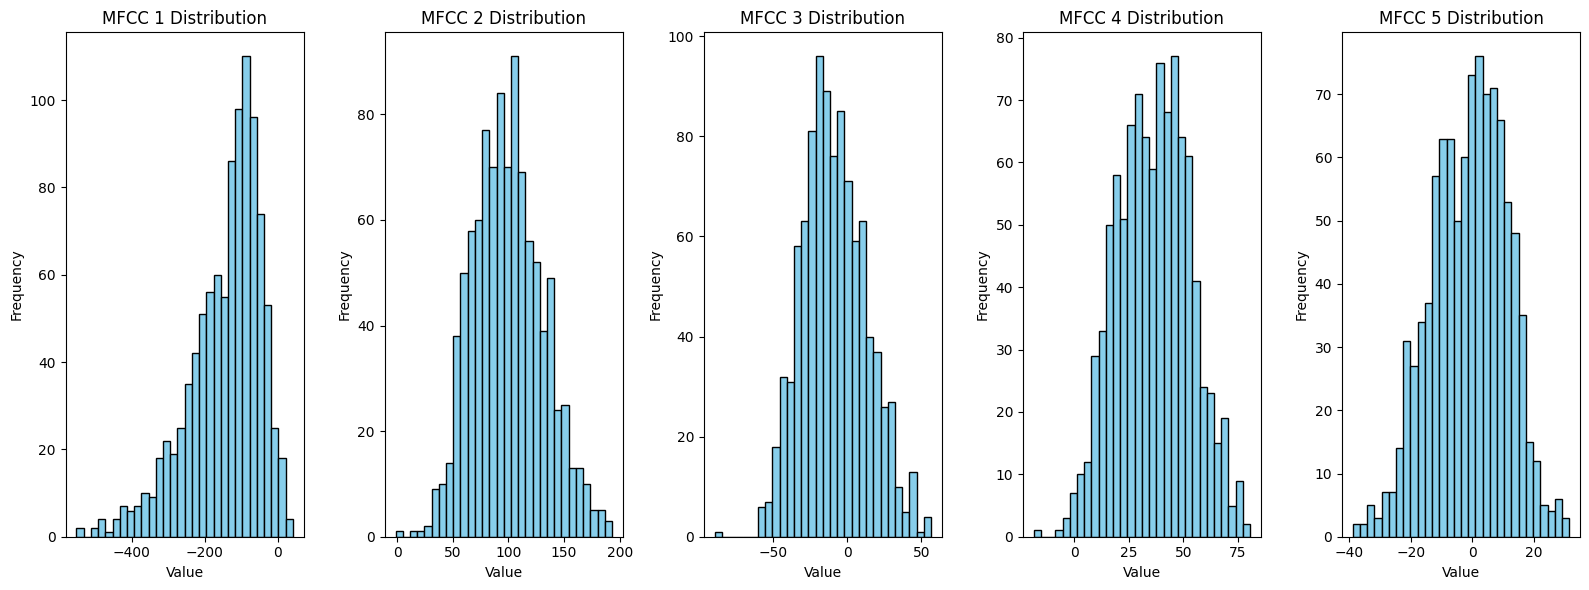

In [ ]:
plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.hist(X[:, i], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'MFCC {i+1} Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(16, 8))
for i in range(5):
    plt.subplot(1, 5, i+1)
    sns.boxplot(x='Class', y=f'MFCC {i+1}', data=mfcc_df, palette='Set2')
    plt.title(f'Box Plot - MFCC {i+1}')
    plt.xlabel('Genre')
    plt.ylabel(f'MFCC {i+1} Value')
plt.tight_layout()
plt.show()